## Introduction
On the tutorial `Simulating sequences with errors and noises`, we introduced effective noise channels and here we will go in deeper details. If you missed that tutorial, please go back there before going through this one.

Effective noise model is based on the concept of Kraus operators which are actors in the Lindblad equation. If you're not familiar with Lindblad equation and want to know deeper about, please check this ressource [here](https://ocw.mit.edu/courses/22-51-quantum-theory-of-radiation-interactions-fall-2012/resources/mit22_51f12_ch8/).

We recall the Lindblad equation:

$\frac{d \rho}{dt} = -i[\mathcal{H}, \rho] + \sum_k \left( L_k \rho L_k^\dagger - \frac{1}{2} \left\{ L_k^\dagger L_k, \rho \right\} \right)$ $\newline$

Operators $L_k$ are what we called *Collapse operators*. Basically, effective noise channel can be fully described by a set of collapse operators which are linked with each other by an equation called the *completeness relationship*:  $\sum_k N_k N_k^\dagger = \mathbb{I}$.

So varying $N_k$ gives birth to different effective noise channels. We will discuss in this tutorial two specific ones:

* The dephasing channel
* The depolarizing channel


In [125]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation, SimConfig
from pulser_simulation.simresults import (
    CoherentResults,
    NoisyResults,
    SimulationResults,
)
from pulser.waveforms import RampWaveform
from pulser.devices import Chadoq2
from pulser.devices._device_datacls import Device
from typing import Union, cast

# The dephasing channel

In this channel, each qubit interacts with its environment, and we can model this interaction with random $Z$-rotations on each qubit according to a given probability $p$, the dephasing probability.

The Corresponding collapse operators are the following: $\newline$
$M_0 = \sqrt{1-\frac{p}{2}} \mathbb{I}$ and $M_1 = \sqrt{\frac{p}{2}} \sigma_z$

### Single atom noise simulation

We prepare a single atom

In [126]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

Act on this atom with a Constant Pulse, such that it oscillates towards the excited Rydberg state and back to the original state (Rabi oscillations):

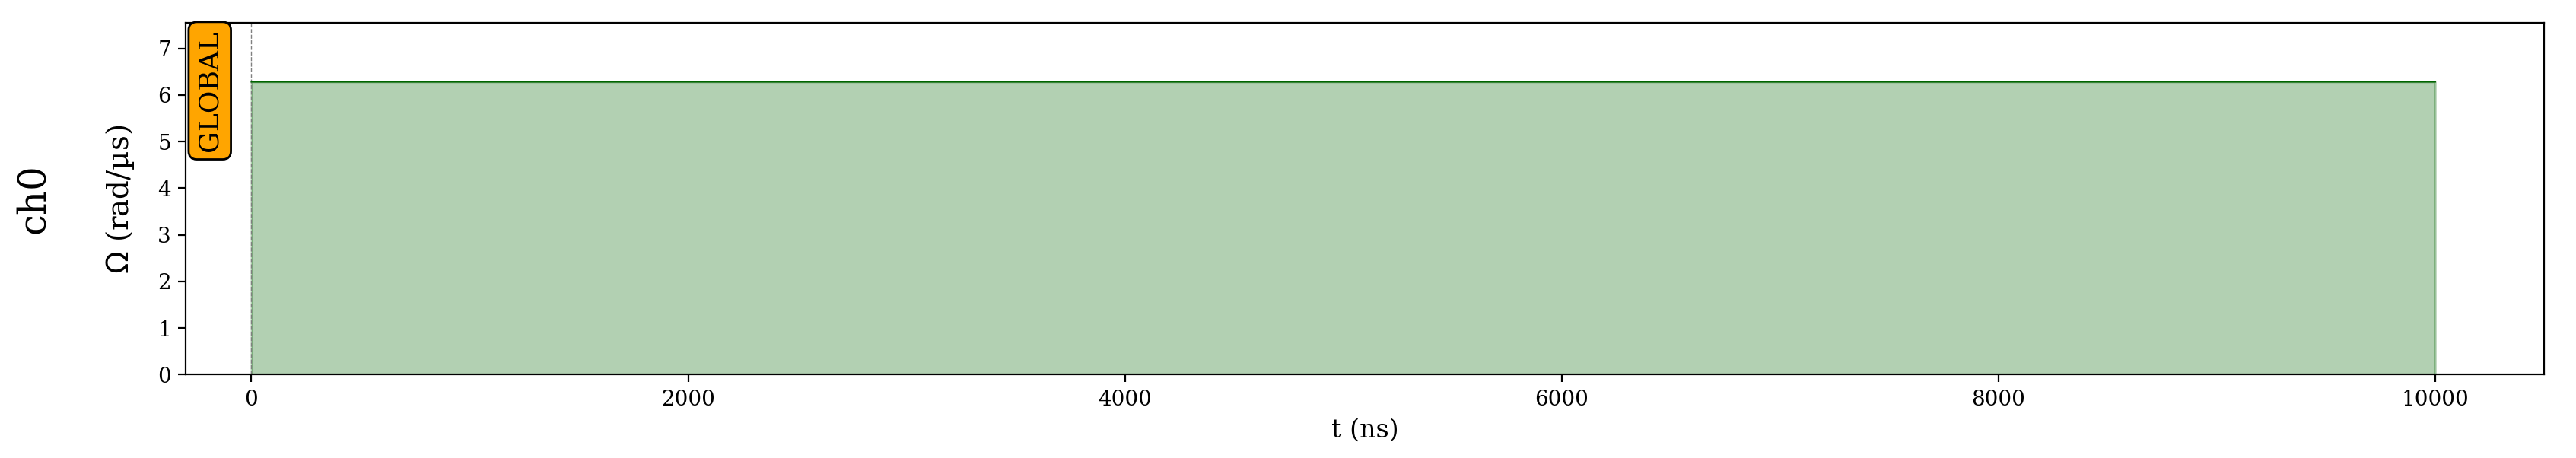

In [127]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0 * np.pi, 0.0)
seq.add(pulse, "ch0")
seq.draw()

The corresponding hamiltonian is $\mathcal{H}(t) = \frac{\hbar \Omega(t)}{2}\sigma^x$

We now run the noiseless simulation

In [128]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()

We can observe the population on the ground state using it's projector

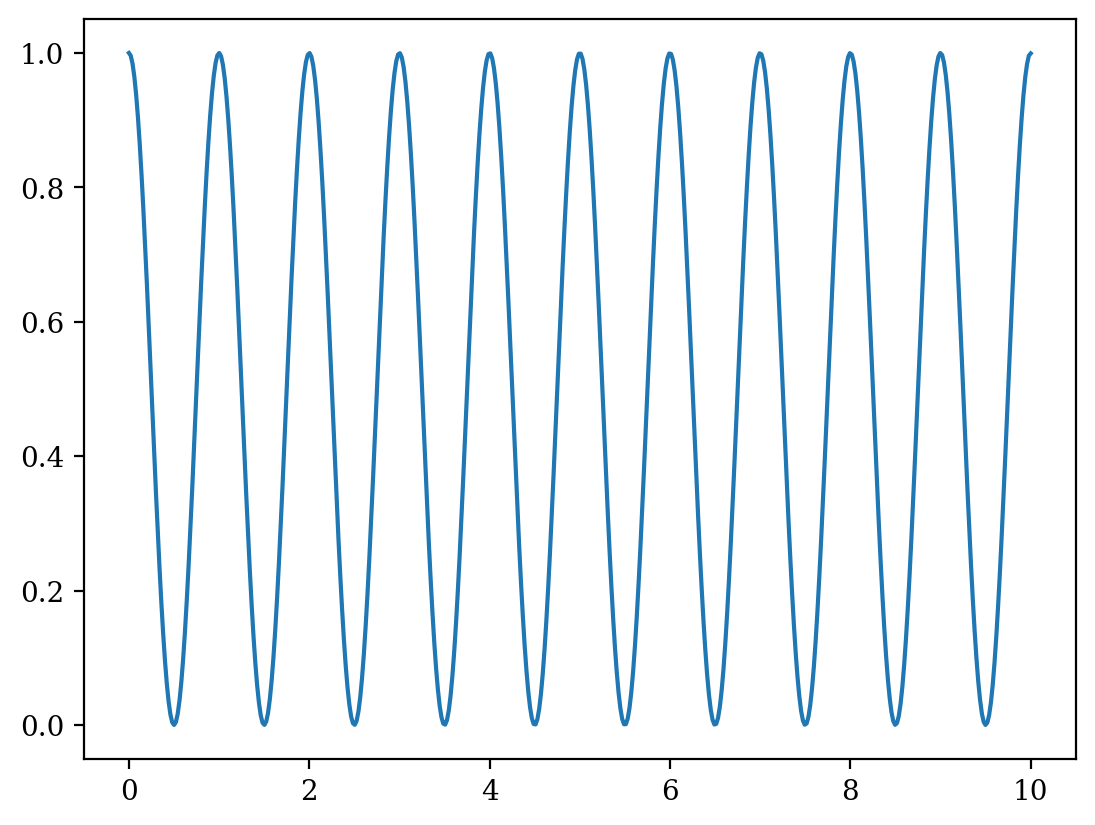

In [129]:
obs = qutip.basis(2, 1).proj()
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0])
plt.show()

The are two ways to define the dephasing channel on pulser.

The first way is by creating a `SimConfig` object, specifying you want the dephasing noise and choosing the *dephasing probability*

In [130]:
config_dephasing = SimConfig(noise="dephasing", dephasing_prob=0.1)
clean_simu.set_config(config_dephasing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           dephasing
Dephasing probability: 0.1


The second way, which is a more general way, allows not only to describe the dephasing noise, but also all effective noise channels.

In [131]:
clean_simu.reset_config()
config_dephasing = SimConfig(
    noise="eff_noise",
    eff_noise_opers=[qutip.qeye(2), qutip.sigmaz()],
    eff_noise_probs=[1 - 0.05, 0.05],
)
clean_simu.add_config(config_dephasing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           eff_noise
Effective noise distribution:       [0.95, 0.05]
Effective noise operators:       [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


Then we clean the simulation for future usage

In [132]:
clean_simu.reset_config()
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5


This is more explicit than the first method since we see the operators corresponding to the effective noise channel. In the case of the *dephasing channel*, the operators are: $\mathbb{I}$ and $\sigma_z$, which is what we see at the right of `Effective noise operators`.

Let us now simulate the entire sequence with the dephasing noise. We should see damped oscillations whenever the dephasing probability is non zero.

We define some useful functions for our simulations.

In [133]:
def get_population(rho, psi_0):
    """
    Expectation value of the input density matrix over a given direction psi_0
    """
    return psi_0.dag() * rho * psi_0


def get_population_evolution(result: SimulationResults, state):
    """
    Evolution of the expectation value of the density matrix along a state over time
    """
    population = []
    for rho_t in result.states:
        population.append(get_population(rho_t, state)[0][0])
    return population


def noisy_dynamics(clean_simu: Simulation, config: SimConfig):
    """
    Noisy simulation and metrics
    """
    simu = deepcopy(clean_simu)
    # Adding noise
    simu.add_config(config)
    result = simu.run()
    return simu, result

Then we run our simulations

In [134]:
dephasing_probabilities = np.linspace(0, 1, 5)
noisy_results = []
n_gaps = []
for dephasing_probability in dephasing_probabilities:
    print("Dephasing probability = ", dephasing_probability)

    # Configure the dephasing noise and run simulation
    config = SimConfig(noise="dephasing", dephasing_prob=dephasing_probability)
    simu, noisy_result = noisy_dynamics(clean_simu, config)
    # Gap from the no noise config
    n_gap = []
    for i in range(len(noisy_result.states)):
        n_gap.append(
            qutip.tracedist(clean_res.states[i], noisy_result.states[i])
        )

    # Storage
    noisy_results.append(noisy_result)
    n_gaps.append(n_gap)

Dephasing probability =  0.0
Dephasing probability =  0.25
Dephasing probability =  0.5
Dephasing probability =  0.75
Dephasing probability =  1.0


#### Population evolution

/home/varda/.virtualenvs/pulser/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


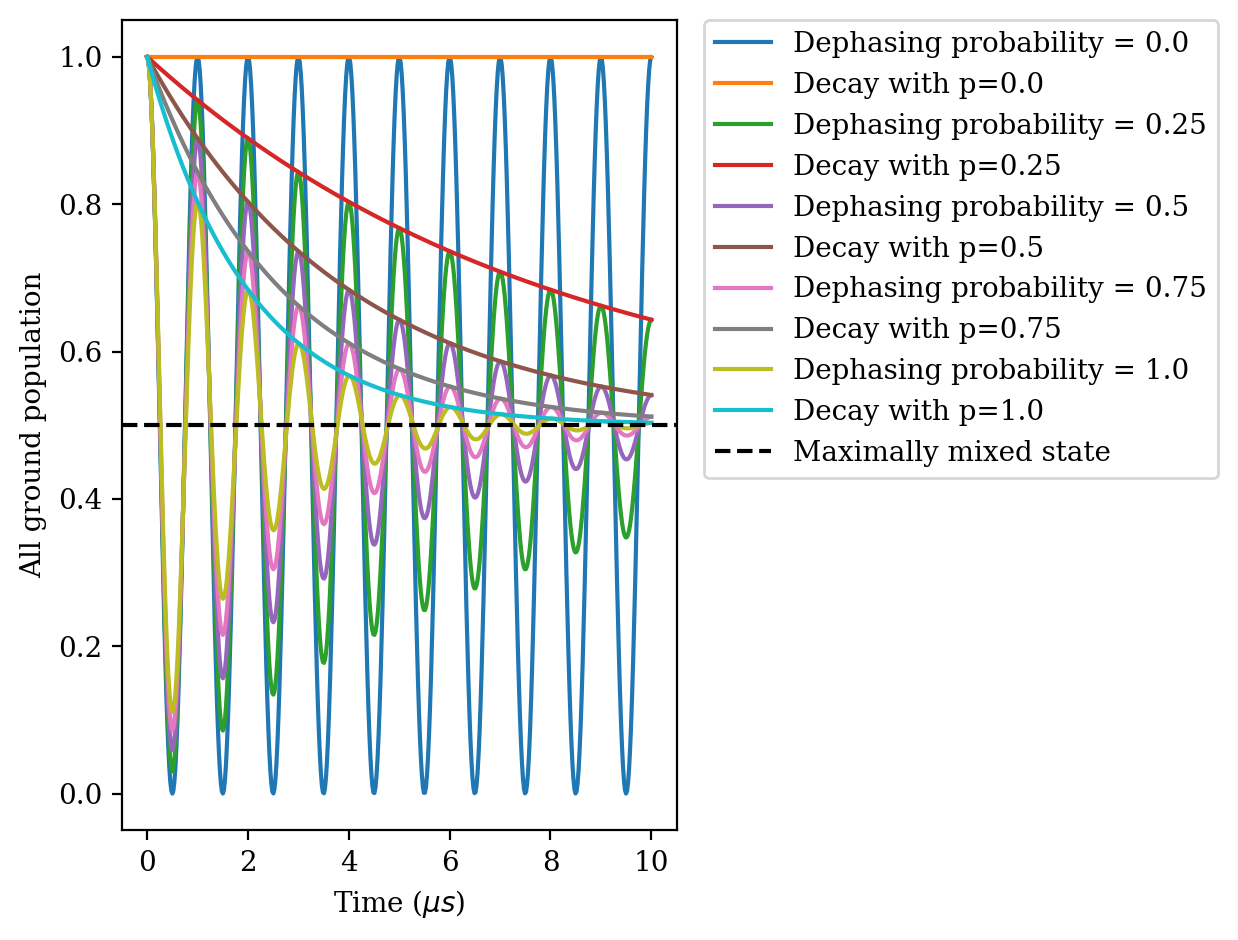

In [141]:
# Ground state population with noise
psi_0 = clean_simu.initial_state
noisy_pops = [
    get_population_evolution(noisy_result, state=psi_0)
    for noisy_result in noisy_results
]
times = noisy_results[0]._sim_times

plt.rc("font", family="serif")
plt.rc("figure", dpi=200)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("All ground population")

for dephasing_probability, noisy_pop in zip(
    dephasing_probabilities, noisy_pops
):
    plt.plot(
        times,
        noisy_pop,
        label=f"Dephasing probability = {dephasing_probability}",
    )
    plt.plot(
        times,
        0.5 * np.exp(-0.5 * dephasing_probability * times) + 0.5,
        label=f"Decay with p={dephasing_probability}",
    )

plt.axhline(0.5, color="black", linestyle="--", label="Maximally mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

When we look at how the population at the ground state evolves with respect to the depahsing probability $p$, we notice that it converges to a stationary value, $0.5$.

It's an exponential damping. We ploted the corresponding exponential damping, but how can we find it theoretically?

We recall the dephasing channel:

$S_d(\rho) = \frac{1 + \Gamma}{2}\rho + \frac{1 - \Gamma}{2} \sigma_z \rho \sigma_z$, $\Gamma = e^{-\frac{t}{T_2}}$ 

$T_2$ is what we call the dephasing time. It describes how long the state remains intact. Be careful, it is not "the time from state x to state y".

With $\frac{t}{T_2} \lll 1 $, $\Gamma = e^{-\frac{t}{T_2}} \approx 1 -\frac{t}{T_2} = \gamma = \frac{p}{2} $. The underlying dephasing channel remains:

$S_d(\rho) = (1 - \gamma)\rho + \gamma \sigma_z \rho \sigma_z = (1 - \frac{p}{2})\rho + \frac{p}{2} \sigma_z \rho \sigma_z$. Now appears our well-known dephasing probability $p$.

The state into which the qubit converges is the $\ket{+}$ state. If we compute $\bra{+}S_d(\rho)\ket{+}$, we will get:

$\bra{+}S_d(\rho)\ket{+} = \frac{1 + \Gamma}{2} = \frac{1 + e^{-\frac{t}{T_2}}}{2} = \frac{1 + e^{-\gamma t}}{2} = \frac{1 + e^{-\frac{p}{2}t}}{2} $

This corresponds to the damping of the all-ground population evolution we represented as *Decay with $p=...* on the figure below.

Our system exponentially converges to the $\ket{+} $ state, and the given exponential corresponds to the $Pr(\ket{+}/dephasing) = \bra{+}S_d(\rho)\ket{+}$ 

The underlying density matrix is then $\rho = \frac{1}{2} \mathbb I$, which is the maximally mixed state. This is a statistical mixture of $|0\rangle$ and $|1\rangle$: $\rho = \frac{1}{2}(|0\rangle\langle 0| + |1\rangle\langle 1|)$. Also a state of maximal uncertainty, or minimal information. We can easily check it by plotting the excited state population.

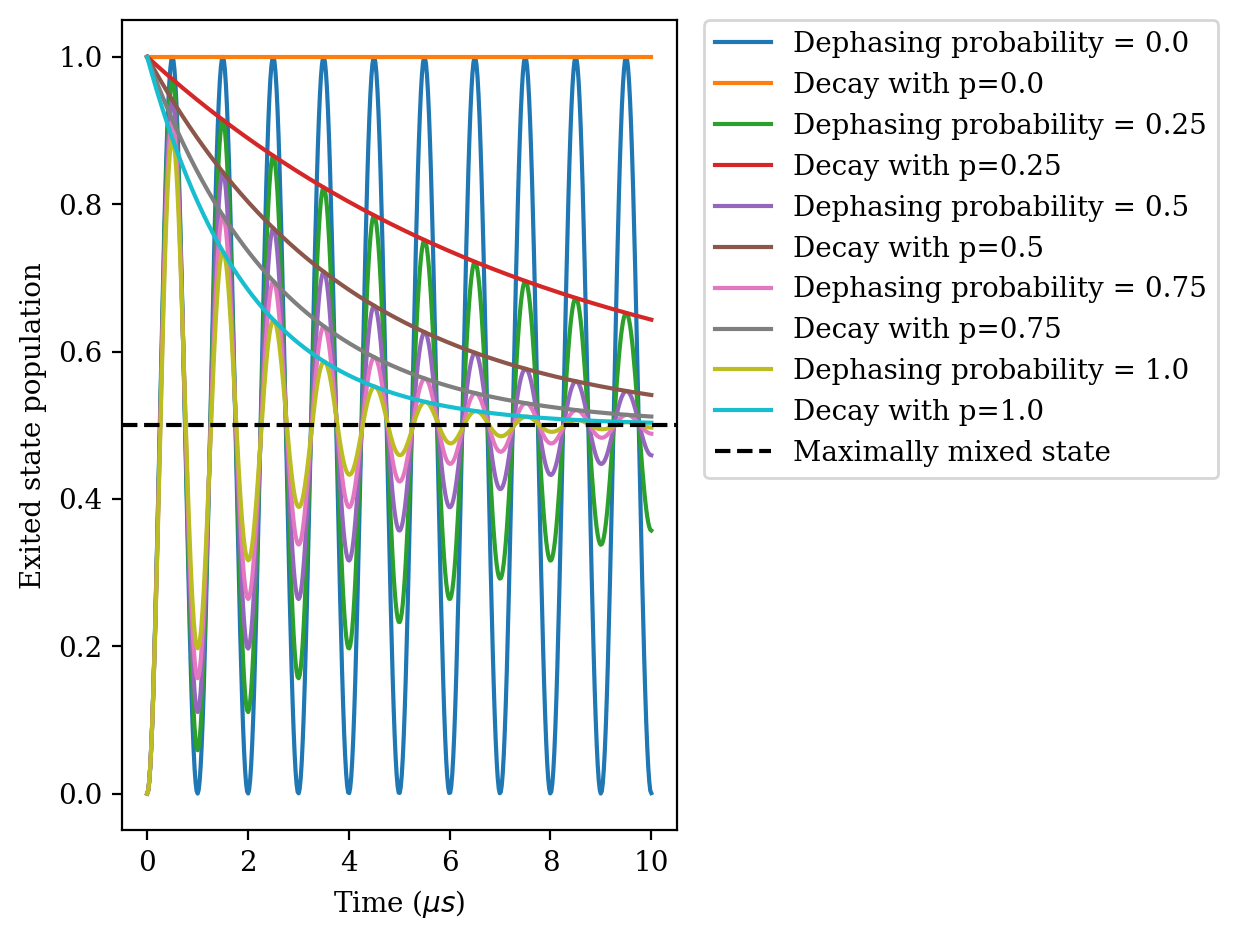

In [142]:
# Ground state population with noise
psi_0 = qutip.basis(2, 0)
noisy_pops = [
    get_population_evolution(noisy_result, state=psi_0)
    for noisy_result in noisy_results
]
times = noisy_results[0]._sim_times

plt.rc("font", family="serif")
plt.rc("figure", dpi=200)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("Exited state population")

for dephasing_probability, noisy_pop in zip(
    dephasing_probabilities, noisy_pops
):
    plt.plot(
        times,
        noisy_pop,
        label=f"Dephasing probability = {dephasing_probability}",
    )
    plt.plot(
        times,
        0.5 * np.exp(-0.5 * dephasing_probability * times) + 0.5,
        label=f"Decay with p={dephasing_probability}",
    )
plt.axhline(0.5, color="black", linestyle="--", label="Maximally mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

#### Trace distance

We can also look at the gap between $\rho_{noise}$ and $\rho_{clean}$ in different dephasing configuration.

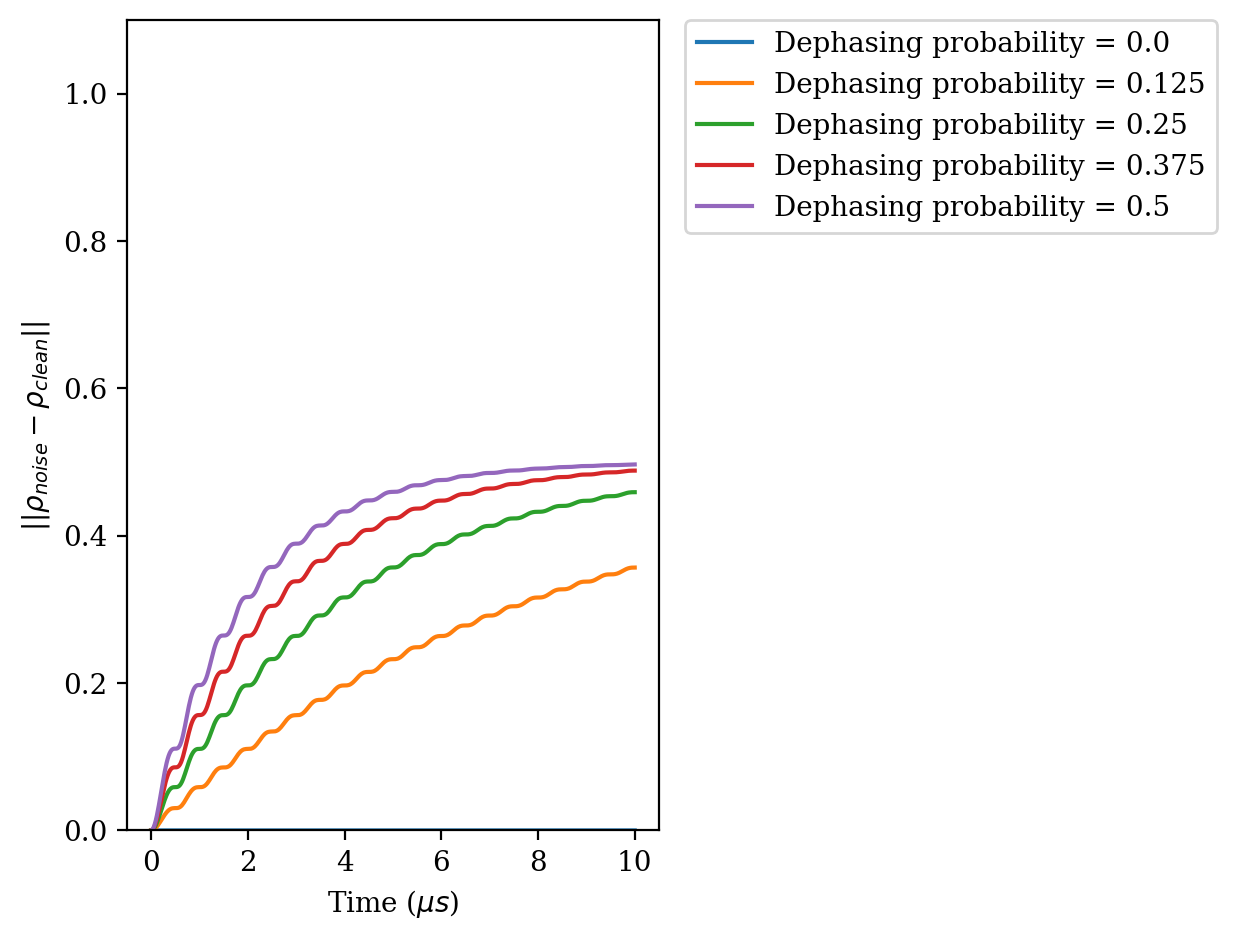

In [143]:
for dephasing_probability, dist in zip(dephasing_probabilities, n_gaps):
    plt.plot(
        times, dist, label=f"Dephasing probability = {dephasing_probability/2}"
    )
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$|| \rho_{noise} - \rho_{clean} || $")
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

The distance converges to $|\rho_{max} - \rho_0|$

### 2-qubit case

We already know what happen in a single qubit configuration. But we would like to study the multi-qubit case. To do so we start with two qubits.

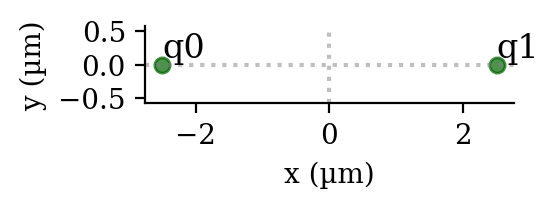

In [144]:
reg = Register.from_coordinates([(0, 0), (5, 0)], prefix="q")

reg.draw()

We will use the same simple pulse

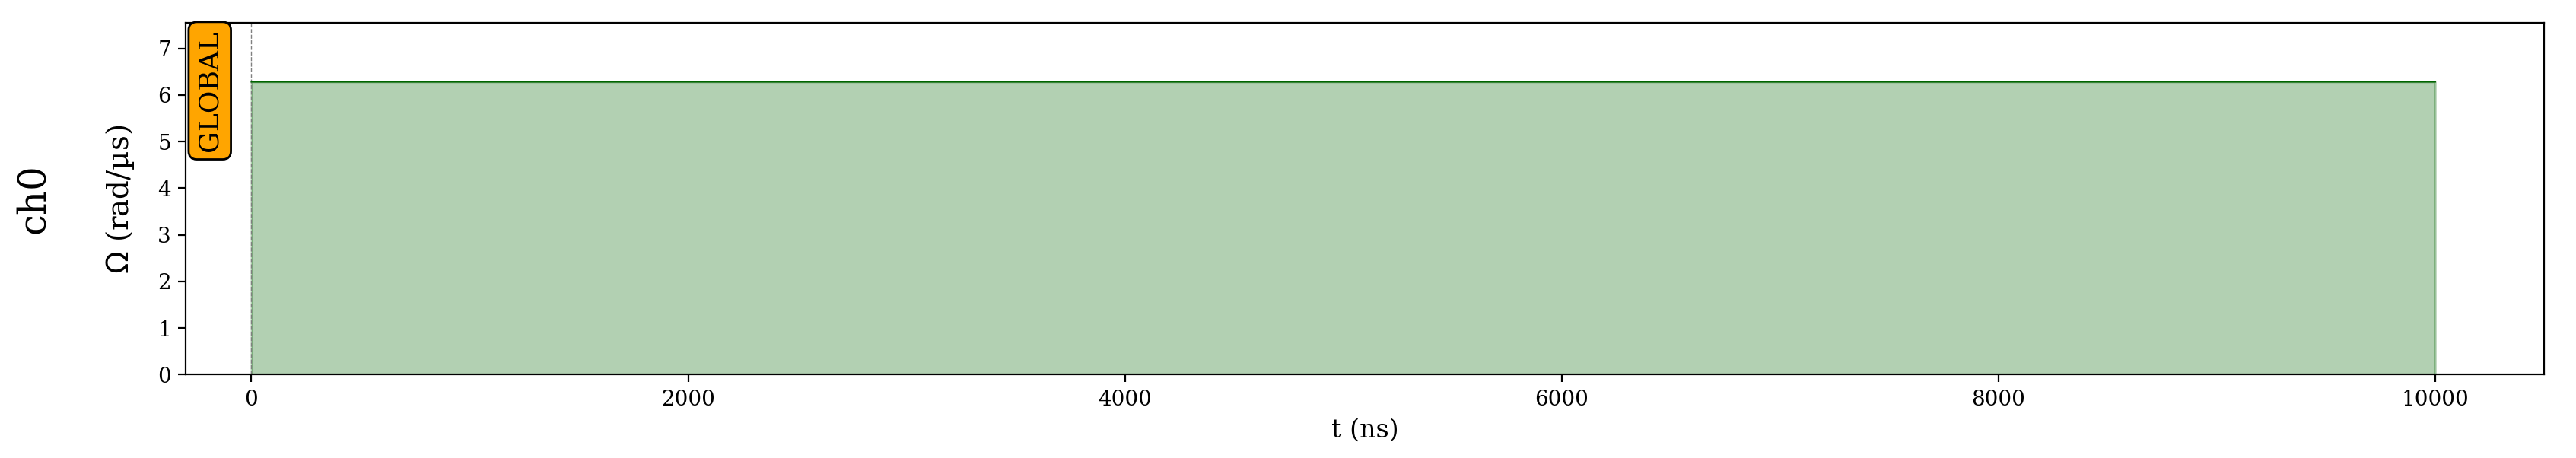

In [158]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 10000
omega = 2 * np.pi
pulse = Pulse.ConstantPulse(duration, omega, 0, 0.0)
seq.add(pulse, "ch0")
seq.draw()

In [160]:
# Rydberg blockade radius
R_interatomic = Chadoq2.rydberg_blockade_radius(omega)
R_interatomic

9.756753962298905

So our two atoms are in the blockade radius. Let's keep it in mind.

An important detail needs to be mentioned. In the multi-qubit case, we made an assumption, we called it, the *uncorrelated noise approximation*. It relies on the fact that the probability of two qubits to undergo an effective noise are independent, i.e:$\\$
$Pr(q_i = Nq_i, q_j= Nq_j) = Pr(q_i = Nq_i) Pr(q_j = Nq_j)$, $\forall i,j$ where $N$ is a noise operator.

Let's take $p = Pr(q_i = Nq_i), \forall i$, and $m$ the number of qubit noised, the underlying probability is $p^m$. Therefore, if $p\ll 1$ we get: $p^m \longrightarrow 0$

So the more likely states are: $Nq_j\otimes_{i\neq j}q_i, \forall j$ all equiprobable.

In [161]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()

When the dephasing probability is higher than $0.2$, we get a warning

In [162]:
config = SimConfig(noise="dephasing", dephasing_prob=0.5)
clean_simu.add_config(config)

/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.5 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


In [163]:
clean_simu.reset_config()
dephasing_probabilities = np.linspace(0, 1, 5)
noisy_results = []
n_gaps = []
for dephasing_probability in dephasing_probabilities:
    print("Dephasing probability = ", dephasing_probability)

    # Configure the dephasing noise and run simulation
    config = SimConfig(noise="dephasing", dephasing_prob=dephasing_probability)
    simu, noisy_result = noisy_dynamics(clean_simu, config)
    # Gap from the no noise config
    n_gap = []
    for i in range(len(noisy_result.states)):
        n_gap.append(
            qutip.tracedist(clean_res.states[i], noisy_result.states[i])
        )

    # Storage
    noisy_results.append(noisy_result)
    n_gaps.append(n_gap)

Dephasing probability =  0.0
Dephasing probability =  0.25


/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.25 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


Dephasing probability =  0.5
Dephasing probability =  0.75


/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.75 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


Dephasing probability =  1.0


/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 1.0 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


#### Population evolution

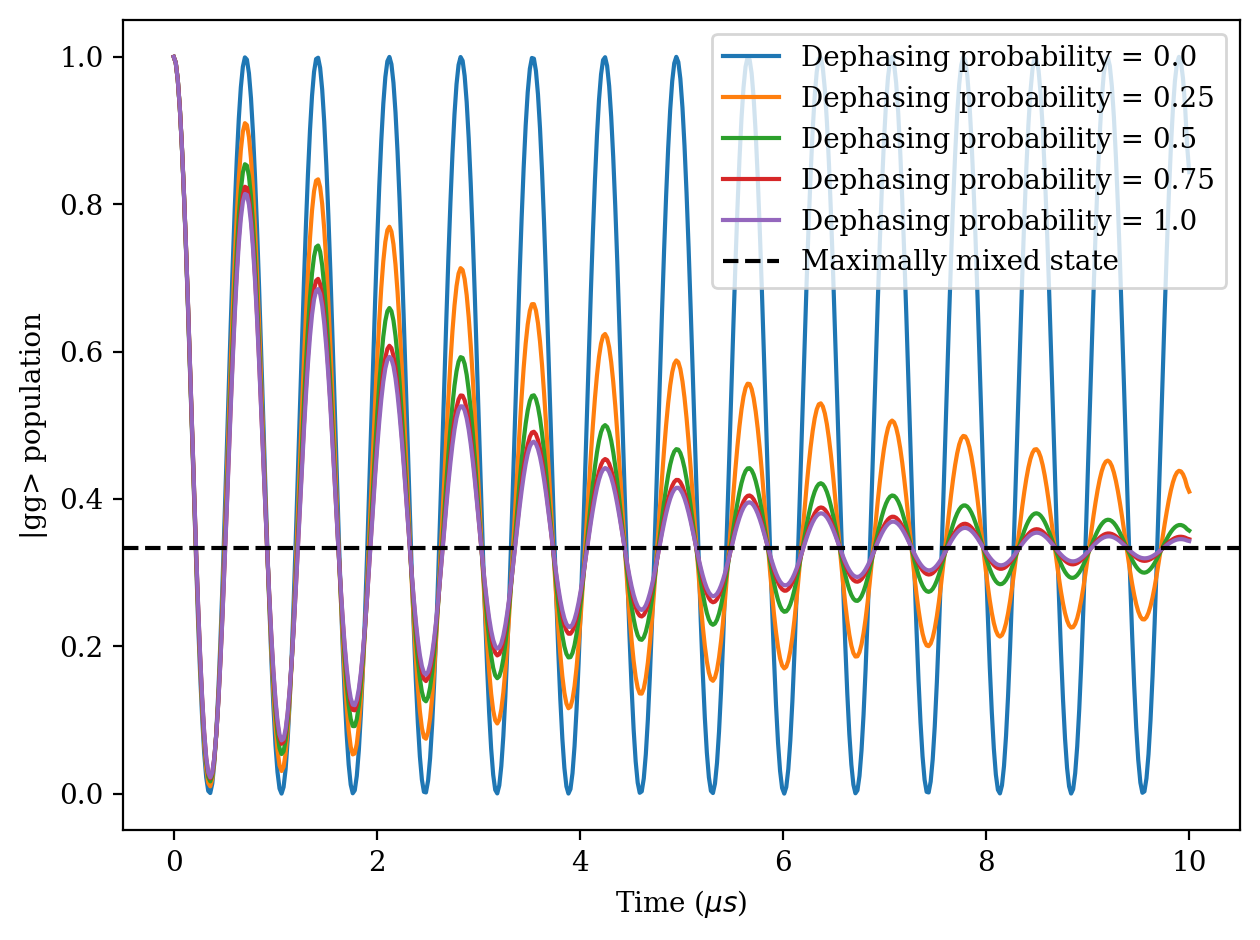

In [169]:
# Ground state population with noise
psi_0 = clean_simu.initial_state
noisy_pops = [
    get_population_evolution(noisy_result, state=psi_0)
    for noisy_result in noisy_results
]
times = noisy_results[0]._sim_times

plt.rc("font", family="serif")
plt.rc("figure", dpi=200)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("|gg> population")

for dephasing_probability, noisy_pop in zip(
    dephasing_probabilities, noisy_pops
):
    plt.plot(
        times,
        noisy_pop,
        label=f"Dephasing probability = {dephasing_probability}",
    )
    # plt.plot(times, 0.5 * np.exp(- 0.5 * dephasing_probability * times) + 0.5, label=f"Decay with p={dephasing_probability}")

plt.axhline(
    1 / 3, color="black", linestyle="--", label="Maximally mixed state"
)

# put labels outside of the plot:
plt.legend()
plt.tight_layout()

Normally, $p>0.2$ is out of our approximation. But in order to see clearly where the population converges, we plotted some samples for $p>0.2$.

Empirically we found that: $\braket{g|\rho(t)|g} $ converges to $\frac{1}{3} $. To verify it let's plot the exited state population.

The effects seems to be the same as that we observed in the single qubit case. Let's increase the distance between qubit

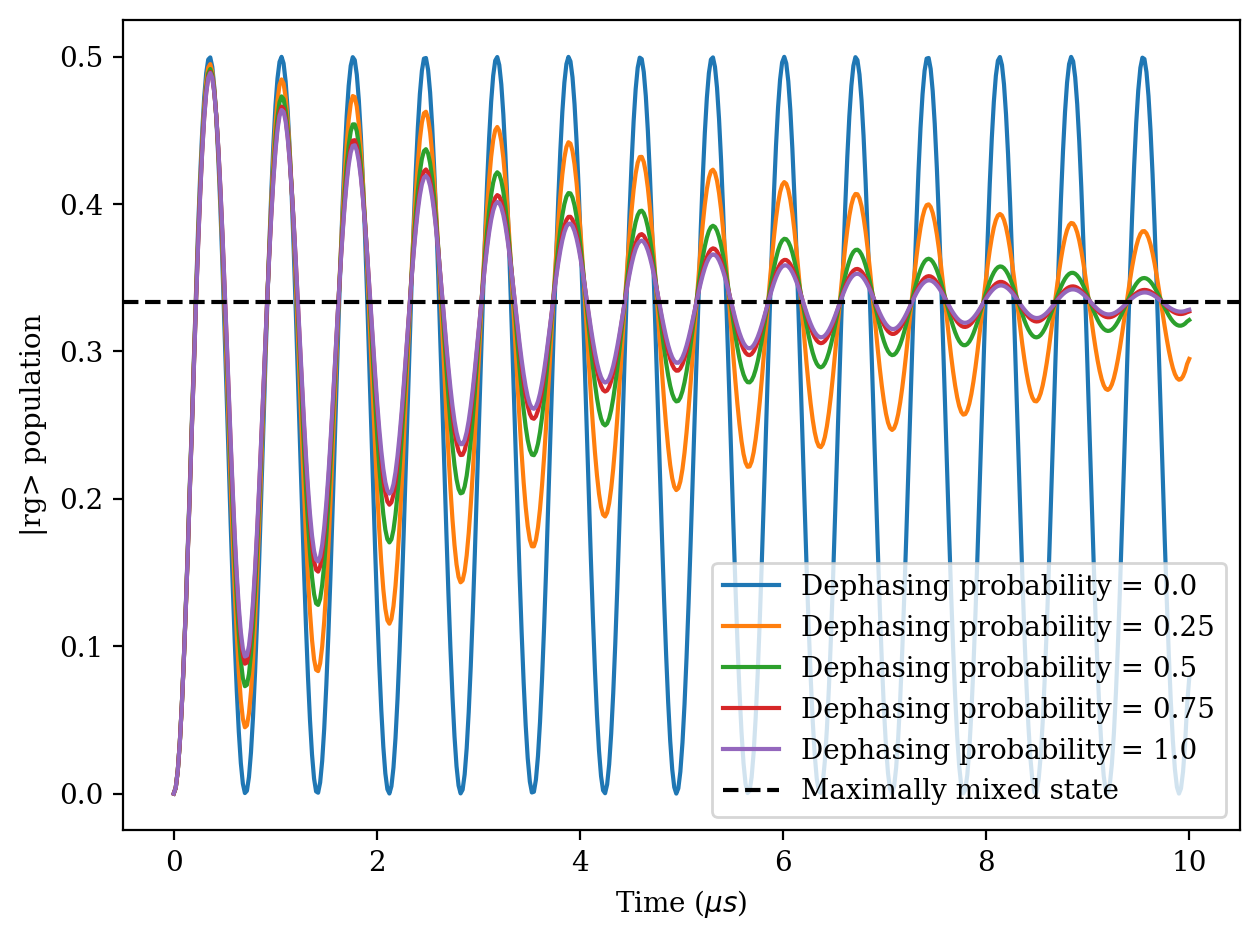

In [170]:
psi_1 = qutip.basis(2, 0)
psi_0 = qutip.basis(2, 1)
psi = qutip.tensor(psi_0, psi_1)
noisy_pops = [
    get_population_evolution(noisy_result, state=psi)
    for noisy_result in noisy_results
]
times = noisy_results[0]._sim_times

plt.rc("font", family="serif")
plt.rc("figure", dpi=200)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("|rg> population")

for dephasing_probability, noisy_pop in zip(
    dephasing_probabilities, noisy_pops
):
    plt.plot(
        times,
        noisy_pop,
        label=f"Dephasing probability = {dephasing_probability}",
    )
plt.axhline(
    1 / 3, color="black", linestyle="--", label="Maximally mixed state"
)

# put labels outside of the plot:
plt.legend()
plt.tight_layout()

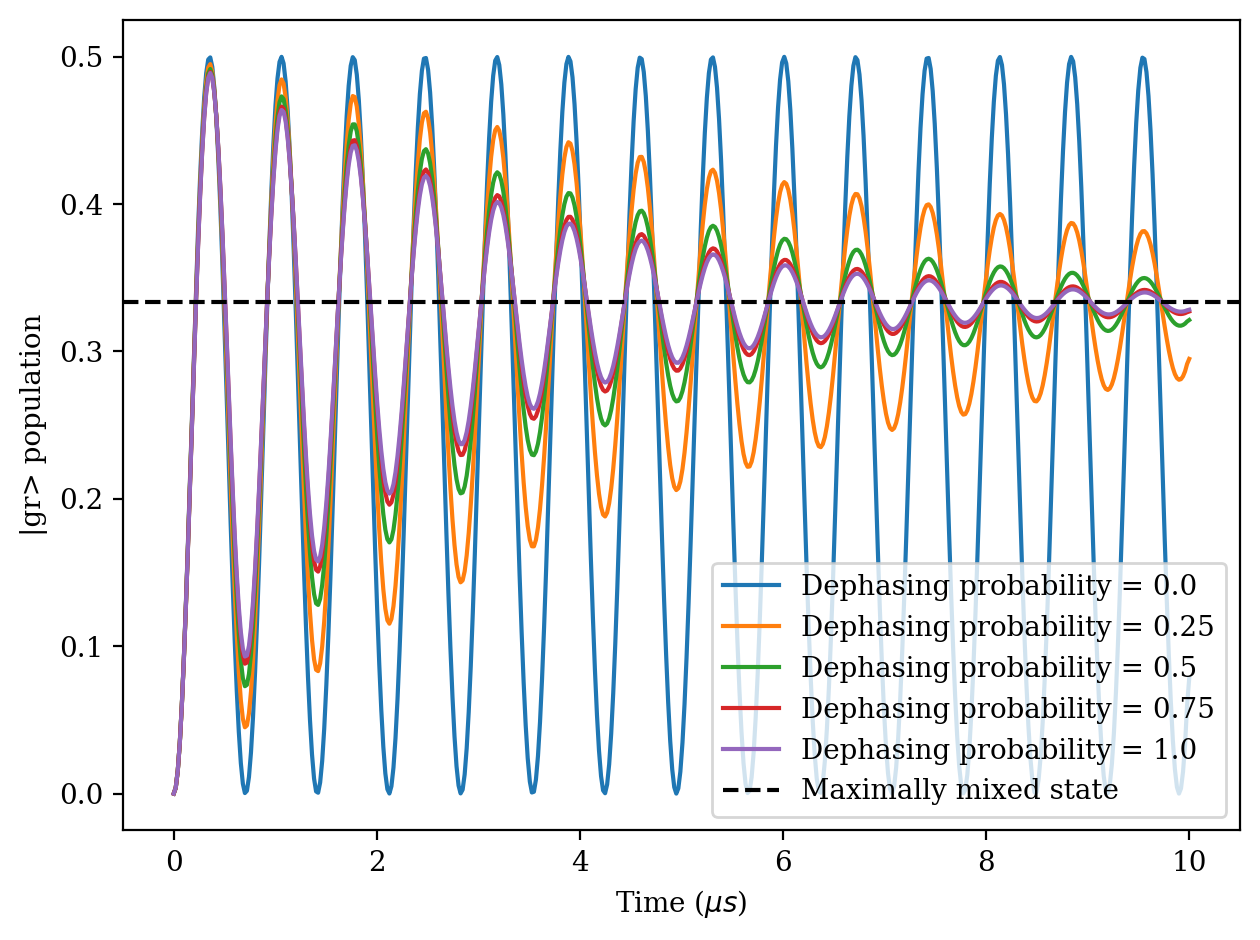

In [171]:
psi_1 = qutip.basis(2, 1)
psi_0 = qutip.basis(2, 0)
psi = qutip.tensor(psi_0, psi_1)
noisy_pops = [
    get_population_evolution(noisy_result, state=psi)
    for noisy_result in noisy_results
]
times = noisy_results[0]._sim_times

plt.rc("font", family="serif")
plt.rc("figure", dpi=200)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("|gr> population")

for dephasing_probability, noisy_pop in zip(
    dephasing_probabilities, noisy_pops
):
    plt.plot(
        times,
        noisy_pop,
        label=f"Dephasing probability = {dephasing_probability}",
    )
plt.axhline(
    1 / 3, color="black", linestyle="--", label="Maximally mixed state"
)

# put labels outside of the plot:
plt.legend()
plt.tight_layout()

The final mixed states is then: 

$\rho = \frac{1}{3} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} ) $

The Rydberg blockades prevent the simultaneous exitation of the two qubits: the dephasing "respects the blockade effect." Let's see what happen with distant atoms.

In [190]:
reg = Register.from_coordinates([(0, 0), (20, 0)], prefix="q")

print(f"20 = R > Ryderg radius = {R_interatomic} ")
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0 * np.pi, 0.0)
seq.add(pulse, "ch0")

20 = R > Ryderg radius = 9.756753962298905 


The blockade effect is broken.

In [191]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()
dephasing_probabilities = np.linspace(0, 1, 5)
noisy_results = []
n_gaps = []
for dephasing_probability in dephasing_probabilities:
    print("Dephasing probability = ", dephasing_probability)

    # Configure the dephasing noise and run simulation
    config = SimConfig(noise="dephasing", dephasing_prob=dephasing_probability)
    simu, noisy_result = noisy_dynamics(clean_simu, config)
    # Gap from the no noise config
    n_gap = []
    for i in range(len(noisy_result.states)):
        n_gap.append(
            qutip.tracedist(clean_res.states[i], noisy_result.states[i])
        )

    # Storage
    noisy_results.append(noisy_result)
    n_gaps.append(n_gap)

Dephasing probability =  0.0
Dephasing probability =  0.25


/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.25 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


Dephasing probability =  0.5


/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.5 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


Dephasing probability =  0.75


/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.75 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


Dephasing probability =  1.0


/home/varda/first_issue/Pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 1.0 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


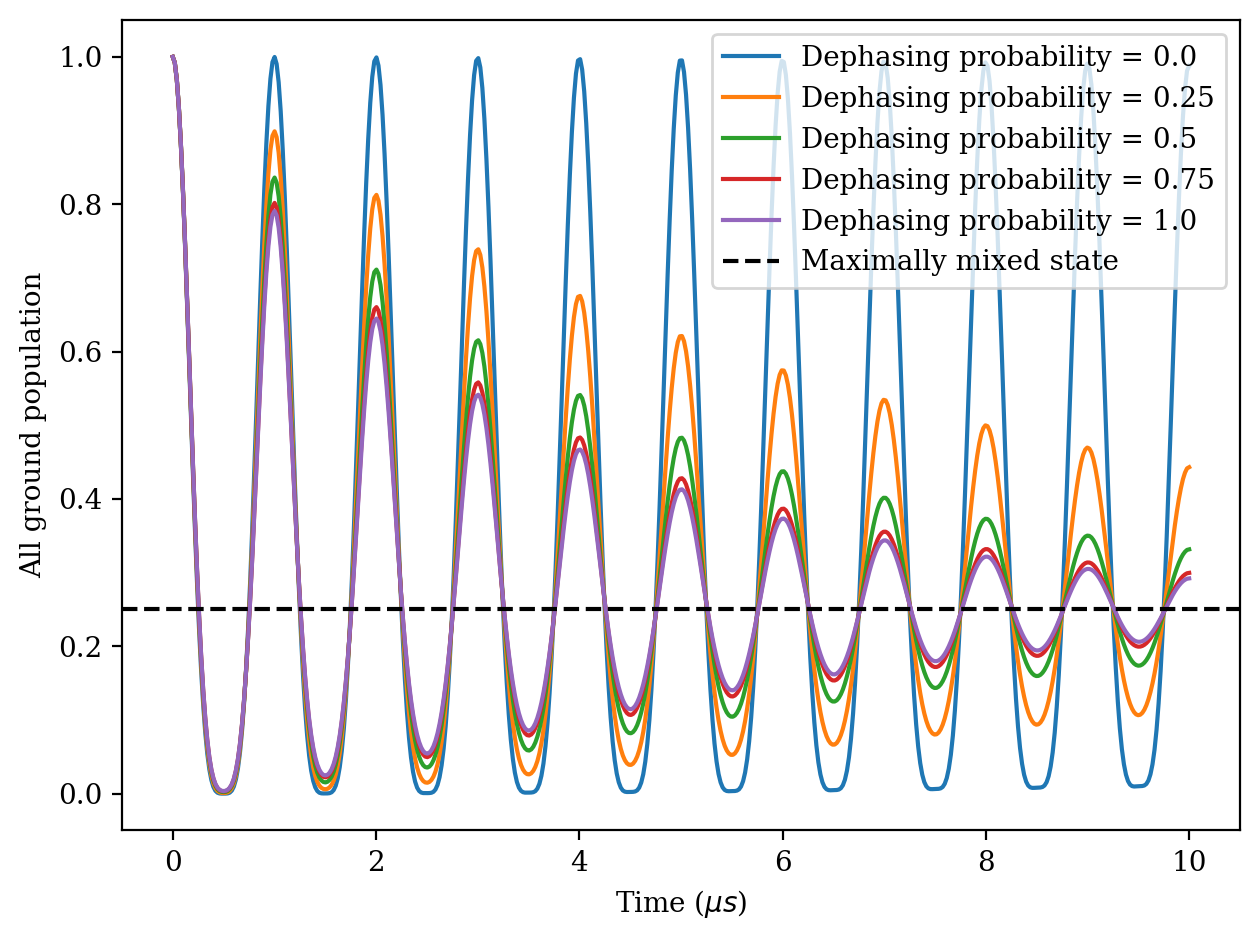

In [192]:
# Ground state population with noise
psi_0 = clean_simu.initial_state
noisy_pops = [
    get_population_evolution(noisy_result, state=psi_0)
    for noisy_result in noisy_results
]
times = noisy_results[0]._sim_times

plt.rc("font", family="serif")
plt.rc("figure", dpi=200)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("All ground population")

for dephasing_probability, noisy_pop in zip(
    dephasing_probabilities, noisy_pops
):
    plt.plot(
        times,
        noisy_pop,
        label=f"Dephasing probability = {dephasing_probability}",
    )
plt.axhline(0.25, color="black", linestyle="--", label="Maximally mixed state")

# put labels outside of the plot:
plt.legend()
plt.tight_layout()

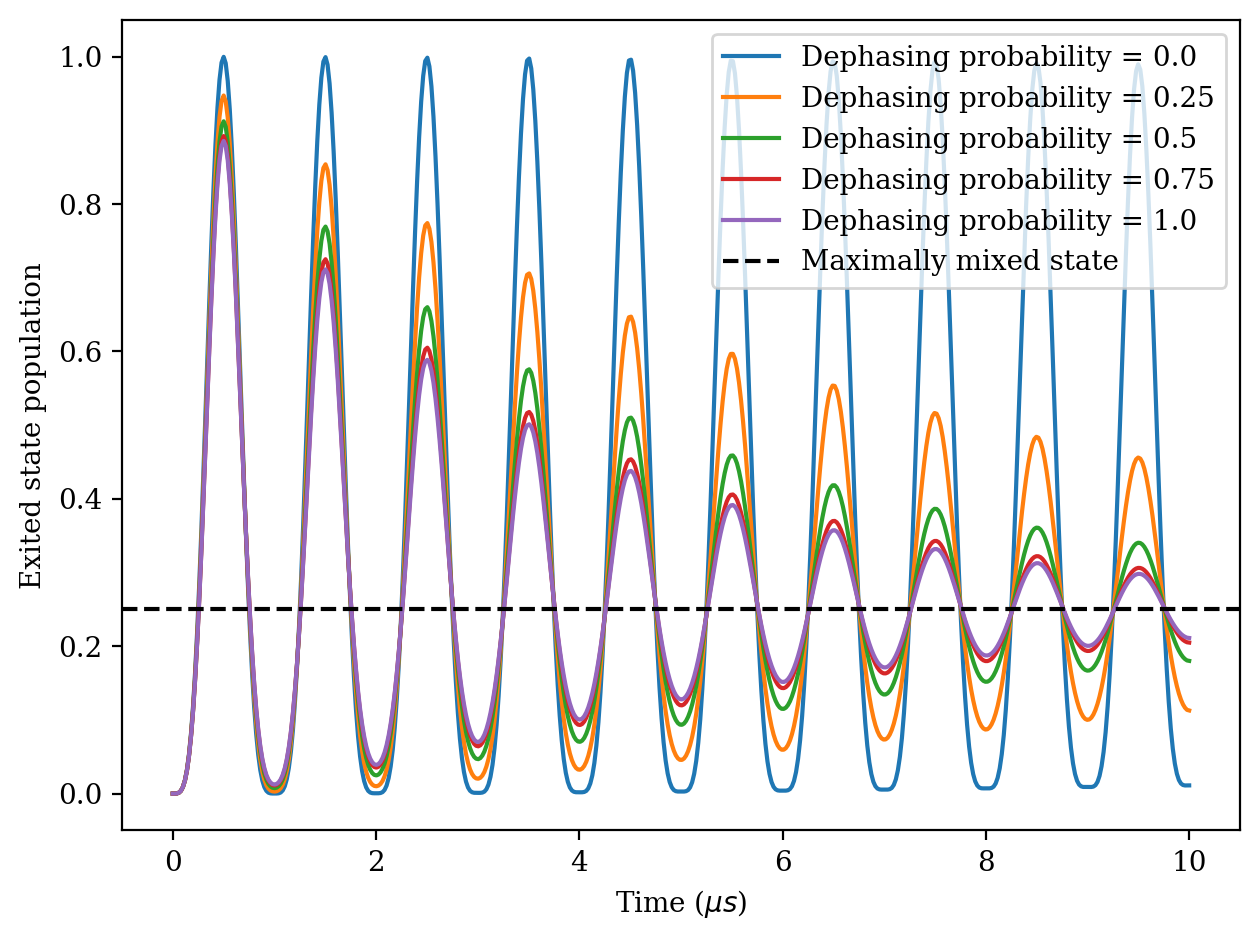

In [193]:
# Exited state population with noise
psi_0 = qutip.basis(2, 0)
psi_1 = qutip.basis(2, 0)
psi = qutip.tensor(psi_0, psi_1)
noisy_pops = [
    get_population_evolution(noisy_result, state=psi)
    for noisy_result in noisy_results
]
times = noisy_results[0]._sim_times

plt.rc("font", family="serif")
plt.rc("figure", dpi=200)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("Exited state population")

for dephasing_probability, noisy_pop in zip(
    dephasing_probabilities, noisy_pops
):
    plt.plot(
        times,
        noisy_pop,
        label=f"Dephasing probability = {dephasing_probability}",
    )
plt.axhline(0.25, color="black", linestyle="--", label="Maximally mixed state")

# put labels outside of the plot:
plt.legend()
plt.tight_layout()

We obtain a non-zero population in the $\ket{rr} $ state as expected. The output mixed state we obtain is:

$\rho = \frac{1}{4} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} + \ket{rr}\bra{rr}) $

The dephasing channel seems to lead the system to an equiprobable mixture of all reachable basis states.

When there was a Rydberg blockade, the three basis states left was: $\ket{gg} $, $\ket{gr} $ and $\ket{rg} $. And the output state was: $\frac{1}{3} (\ket{gg} + \ket{gr} + \ket{rg}) $.

And here since the blockade is broken, the system can reach the all exited state $\ket{rr} $ so the corresponding output is: $\frac{1}{4} (\ket{gg} + \ket{gr} + \ket{rg} + \ket{rr})$